# Segment 1: Introduction to Vision Interpretability & CNN Basics

Before diving into interpretability techniques, we need a clear mental model of how CNNs process images. This notebook covers the essentials:

1. **How images enter the CNN** - pixels as a 3D tensor (H × W × C)
2. **Convolutional filters as pattern detectors** - small learned templates that slide across the image
3. **Spatial locality & weight sharing** - why CNNs are efficient and translation-invariant
4. **Depth → abstraction** - early layers detect edges, later layers detect objects

We'll use **InceptionV1** (GoogLeNet) throughout this project.

In [1]:
# Cell 1: Load InceptionV1 and visualize its structure
import torch
import torchvision.models as models
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms
from PIL import Image
import requests
from io import BytesIO

# Load pretrained InceptionV1 (GoogLeNet)
model = models.googlenet(pretrained=True)
model.eval()

# Print the model architecture to see the hierarchy
print("InceptionV1 Architecture Overview:")
print("=" * 50)
for name, module in list(model.named_children())[:10]:
    print(f"{name}: {module.__class__.__name__}")
print("...")
print(f"\nTotal layers/modules: {len(list(model.named_modules()))}")

/mnt/efs/rohingarg/cri/cohere-vision-interpretability/cv-env/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/mnt/efs/rohingarg/cri/cohere-vision-interpretability/cv-env/.venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=GoogLeNet_Weights.IMAGENET1K_V1`. You can also use `weights=GoogLeNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


InceptionV1 Architecture Overview:
conv1: BasicConv2d
maxpool1: MaxPool2d
conv2: BasicConv2d
conv3: BasicConv2d
maxpool2: MaxPool2d
inception3a: Inception
inception3b: Inception
maxpool3: MaxPool2d
inception4a: Inception
inception4b: Inception
...

Total layers/modules: 224


## How Images Enter the CNN

An image is just a 3D array of numbers:
- **Height × Width × Channels** (e.g., 224 × 224 × 3 for RGB)
- Each pixel has 3 values (Red, Green, Blue) ranging from 0-255
- We normalize to [-1, 1] or [0, 1] for training stability

The CNN sees this tensor and progressively transforms it through layers.

Loaded dog image from PyTorch Hub


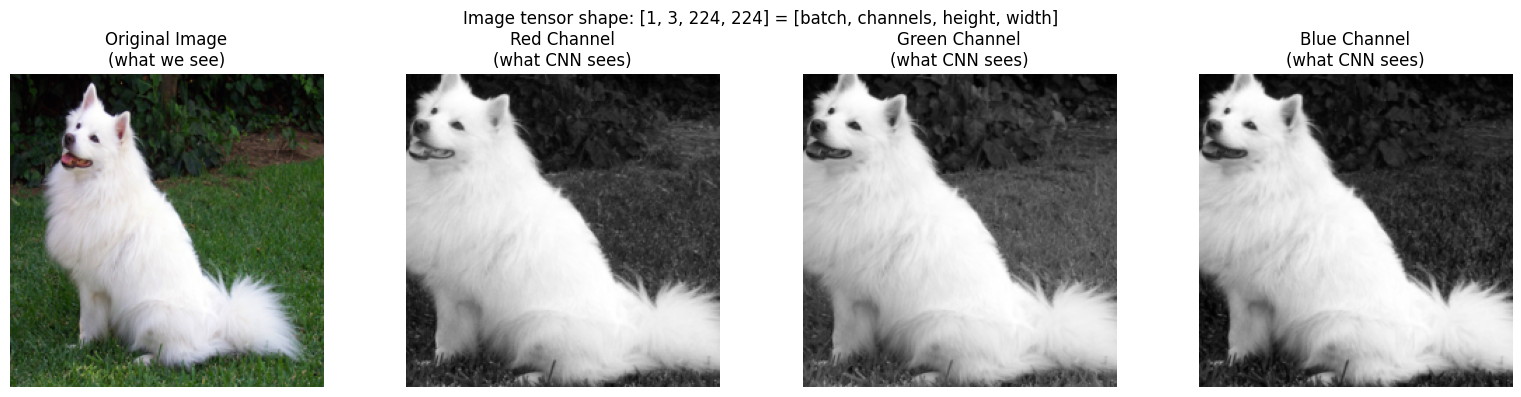


Pixel value range after normalization: [-2.10, 2.64]


In [2]:
# Cell 2: Load an image and show what the CNN "sees"
# Use a reliable image URL (raw GitHub hosted image)
url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"

# Add headers to avoid blocks
headers = {'User-Agent': 'Mozilla/5.0'}
response = requests.get(url, headers=headers)

# Check if request succeeded
if response.status_code != 200:
    # Fallback: create a synthetic image
    print(f"URL failed (status {response.status_code}), using synthetic image")
    img = Image.fromarray(np.uint8(np.random.rand(256, 256, 3) * 255))
else:
    img = Image.open(BytesIO(response.content)).convert('RGB')
    print("Loaded dog image from PyTorch Hub")

# Standard ImageNet preprocessing
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img_tensor = preprocess(img).unsqueeze(0)  # Add batch dimension: [1, 3, 224, 224]

fig, axes = plt.subplots(1, 4, figsize=(16, 4))

# Original image
axes[0].imshow(img.resize((224, 224)))
axes[0].set_title("Original Image\n(what we see)")
axes[0].axis('off')

# Show each channel separately
channel_names = ['Red Channel', 'Green Channel', 'Blue Channel']
for i, (ax, name) in enumerate(zip(axes[1:], channel_names)):
    # Denormalize for visualization
    channel = img_tensor[0, i].numpy()
    ax.imshow(channel, cmap='gray')
    ax.set_title(f"{name}\n(what CNN sees)")
    ax.axis('off')

plt.suptitle(f"Image tensor shape: {list(img_tensor.shape)} = [batch, channels, height, width]", fontsize=12)
plt.tight_layout()
plt.show()

print(f"\nPixel value range after normalization: [{img_tensor.min():.2f}, {img_tensor.max():.2f}]")

## Convolutional Filters: Local Pattern Detectors

The key insight of CNNs: **small learned filters slide across the image**, detecting local patterns.

- A 3×3 filter looks at 9 pixels at a time
- It computes a weighted sum (dot product) at each position
- The same filter is applied everywhere (**weight sharing**)
- Different filters learn to detect different patterns

**Early layers** learn simple patterns (edges, colors, textures).  
**Later layers** combine these into complex patterns (eyes, wheels, faces).

First conv layer filter shape: [64, 3, 7, 7]
  = [num_filters, input_channels, height, width]
  = 64 filters, each looking at 3 channels, size 7x7


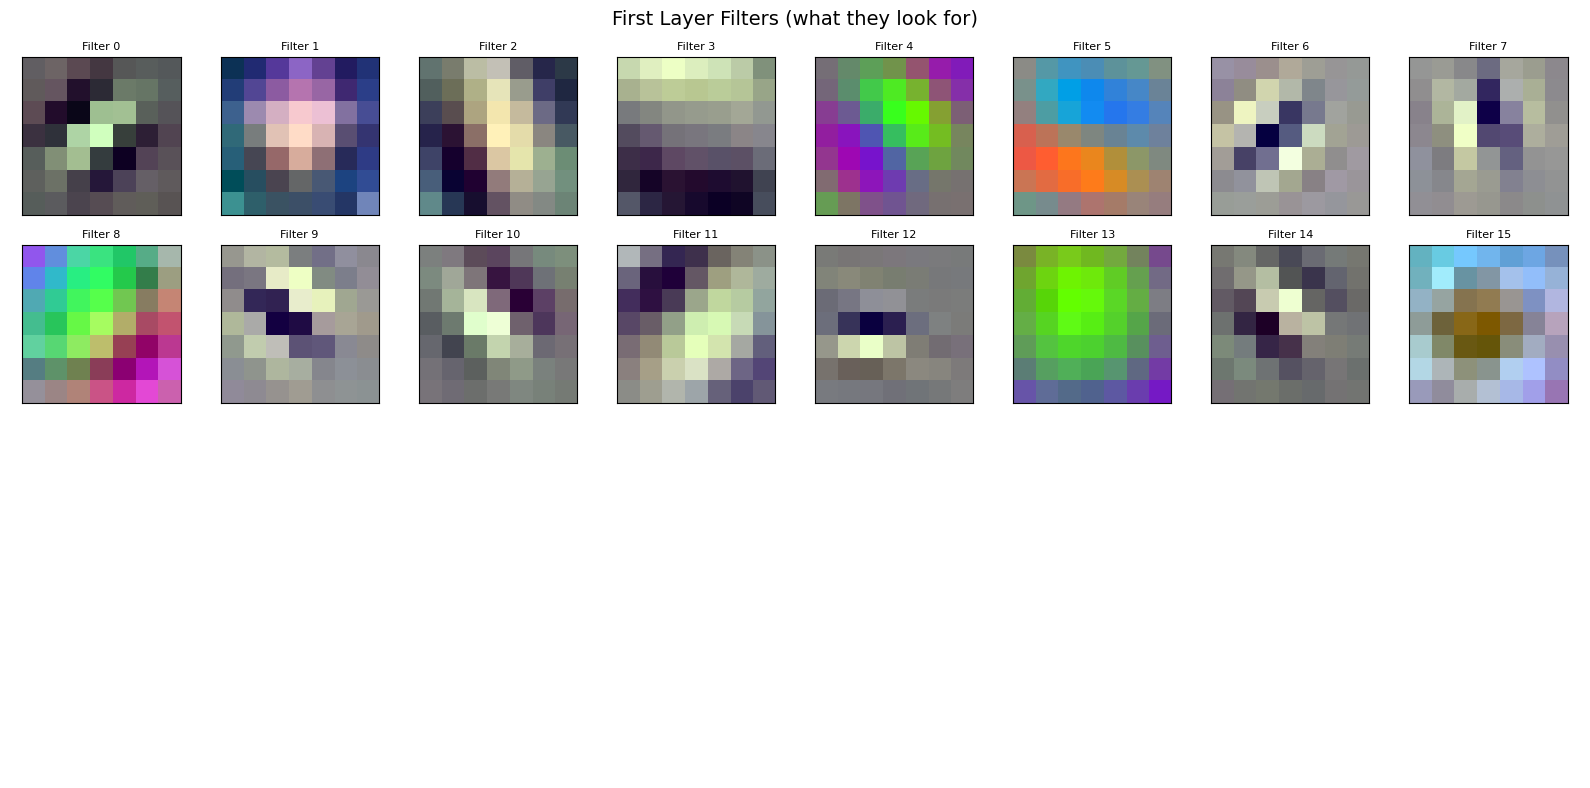

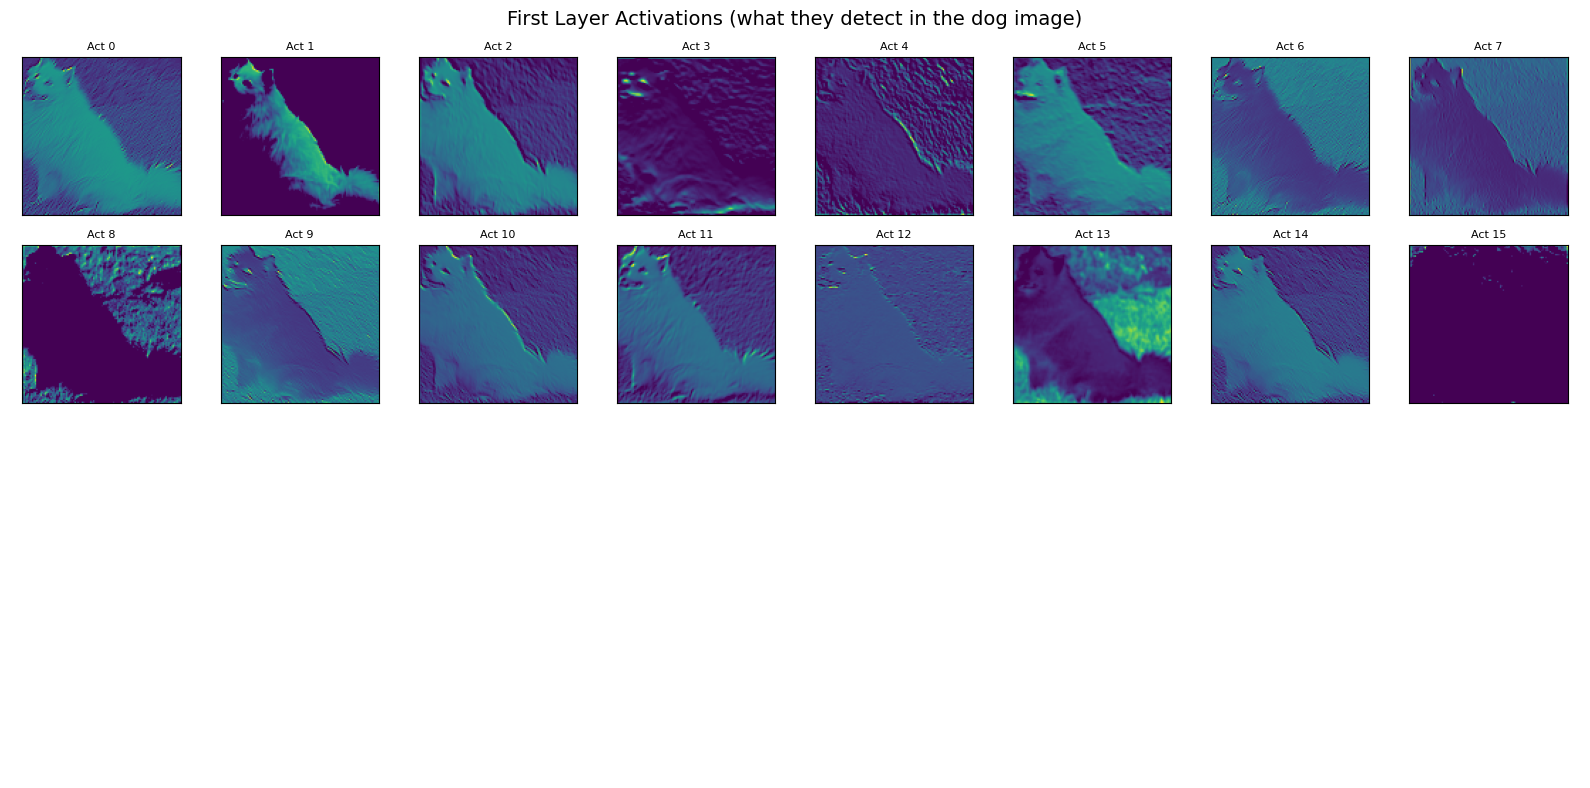

In [3]:
# Cell 3: Visualize first-layer filters and their activations
# Get the first conv layer filters
first_conv = model.conv1.conv  # InceptionV1's first 7x7 conv
filters = first_conv.weight.data.clone()

print(f"First conv layer filter shape: {list(filters.shape)}")
print(f"  = [num_filters, input_channels, height, width]")
print(f"  = {filters.shape[0]} filters, each looking at {filters.shape[1]} channels, size {filters.shape[2]}x{filters.shape[3]}")

# Visualize first 16 filters
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for idx, ax in enumerate(axes.flat[:32]):
    if idx < 16:
        # Show filter weights (normalize for visualization)
        f = filters[idx].permute(1, 2, 0).numpy()  # [H, W, C]
        f = (f - f.min()) / (f.max() - f.min())  # Normalize to [0, 1]
        ax.imshow(f)
        ax.set_title(f"Filter {idx}", fontsize=8)
    else:
        ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

# Now show activations for our dog image
fig.suptitle("First Layer Filters (what they look for)", fontsize=14)
plt.tight_layout()
plt.show()

# Get activations from first conv layer
activations = {}
def hook_fn(name):
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

model.conv1.register_forward_hook(hook_fn('conv1'))
with torch.no_grad():
    _ = model(img_tensor)

# Show what these filters detect in our image
conv1_acts = activations['conv1'][0]  # [64, H, W]
fig, axes = plt.subplots(4, 8, figsize=(16, 8))

for idx, ax in enumerate(axes.flat[:32]):
    if idx < 16:
        ax.imshow(conv1_acts[idx].numpy(), cmap='viridis')
        ax.set_title(f"Act {idx}", fontsize=8)
    else:
        ax.axis('off')
    ax.set_xticks([])
    ax.set_yticks([])

fig.suptitle("First Layer Activations (what they detect in the dog image)", fontsize=14)
plt.tight_layout()
plt.show()

## Depth Creates Abstraction: From Edges to Objects

This is the key insight for interpretability:

| Layer Depth | What it detects | Example |
|-------------|-----------------|----------|
| **Layer 1** | Edges, colors, simple gradients | Horizontal edge, blue patch |
| **Layer 2-3** | Textures, curves, corners | Fur texture, curve segment |
| **Layer 4-5** | Parts, patterns | Eye, ear, wheel |
| **Final layers** | Objects, scenes | Dog face, car, building |

Each layer builds on the previous: **curves are made of edges**, **circles are made of curves**, **eyes are made of circles + textures**.

This is exactly what the Circuits paper explores - tracing how simple features combine into complex ones.

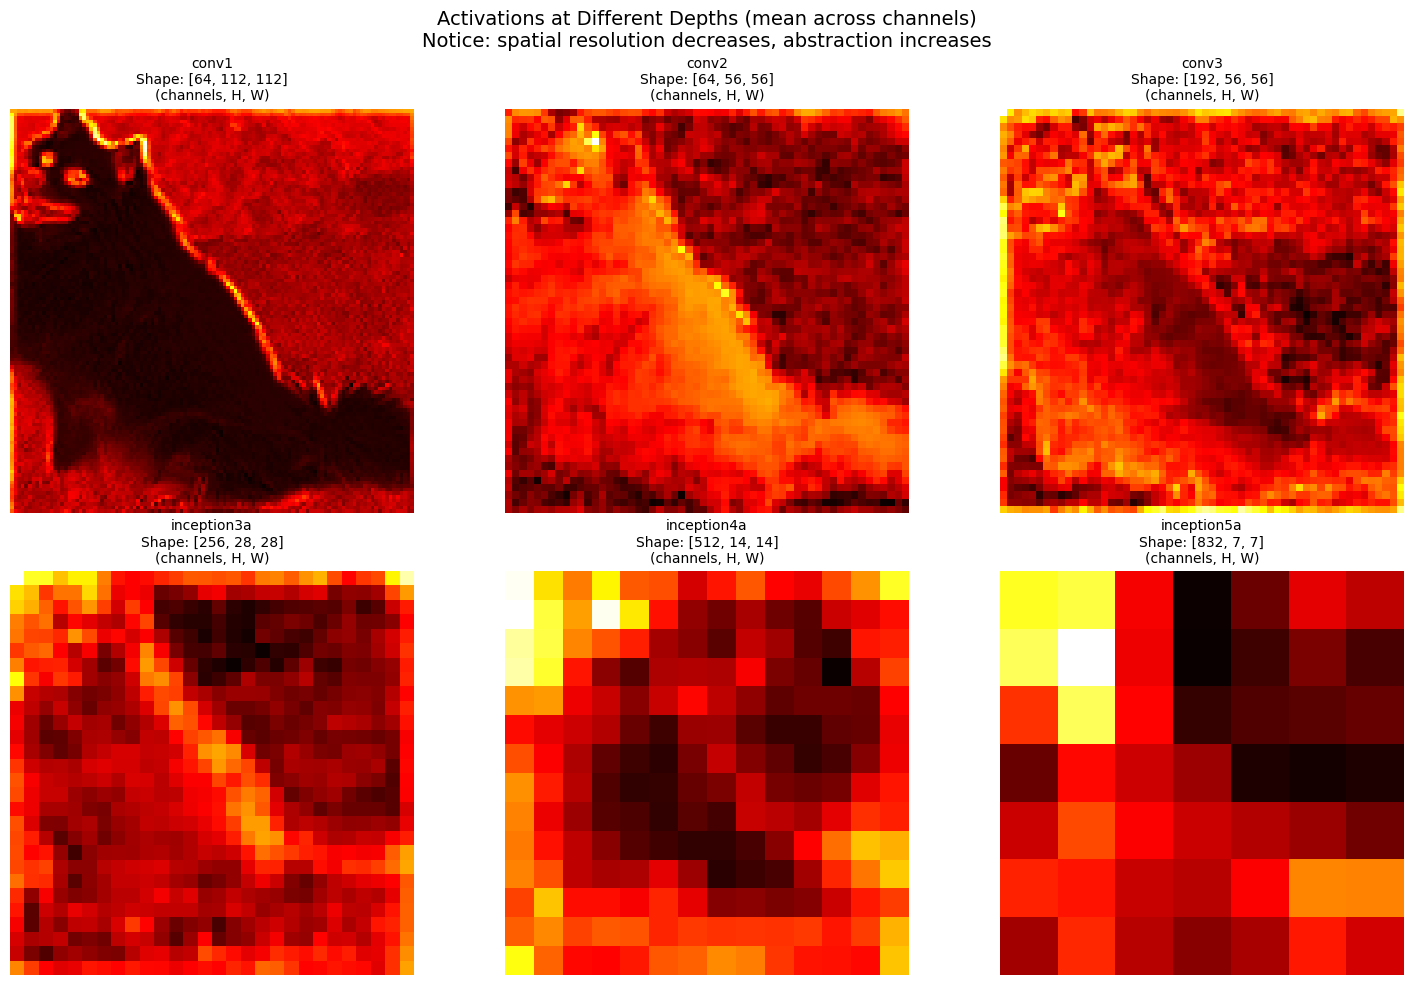


Feature Progression Through the Network:
conv1           ->   64 channels, 112x112 spatial
conv2           ->   64 channels,  56x 56 spatial
conv3           ->  192 channels,  56x 56 spatial
inception3a     ->  256 channels,  28x 28 spatial
inception4a     ->  512 channels,  14x 14 spatial
inception5a     ->  832 channels,   7x  7 spatial

Key Insight: As we go deeper:
  - More channels (more types of features)
  - Smaller spatial size (more abstract, less localized)
  - Each 'pixel' represents a larger receptive field


In [4]:
# Cell 4: Compare activations across different depths
# Register hooks at different layers
layer_names = ['conv1', 'conv2', 'conv3', 'inception3a', 'inception4a', 'inception5a']
hooks = []

def get_activation(name):
    def hook(module, input, output):
        activations[name] = output.detach()
    return hook

# Register hooks
for name, module in model.named_modules():
    if name in layer_names:
        hooks.append(module.register_forward_hook(get_activation(name)))

# Forward pass
with torch.no_grad():
    output = model(img_tensor)

# Show one representative activation from each layer
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, (name, ax) in enumerate(zip(layer_names, axes.flat)):
    if name in activations:
        act = activations[name][0]  # Remove batch dim
        
        # Take mean across channels to show overall activation pattern
        mean_act = act.mean(dim=0).numpy()
        
        ax.imshow(mean_act, cmap='hot')
        ax.set_title(f"{name}\nShape: {list(act.shape)}\n(channels, H, W)", fontsize=10)
        ax.axis('off')

plt.suptitle("Activations at Different Depths (mean across channels)\n" + 
             "Notice: spatial resolution decreases, abstraction increases", fontsize=14)
plt.tight_layout()
plt.show()

# Clean up hooks
for h in hooks:
    h.remove()

# Print the progression
print("\nFeature Progression Through the Network:")
print("=" * 60)
for name in layer_names:
    if name in activations:
        shape = activations[name].shape
        print(f"{name:15} -> {shape[1]:4} channels, {shape[2]:3}x{shape[3]:3} spatial")

print("\n" + "=" * 60)
print("Key Insight: As we go deeper:")
print("  - More channels (more types of features)")
print("  - Smaller spatial size (more abstract, less localized)")
print("  - Each 'pixel' represents a larger receptive field")

## Summary: Why This Matters for Interpretability

Understanding CNN structure helps us interpret what's happening inside:

1. **Features are meaningful** - Each channel/neuron detects something specific
2. **Hierarchy is real** - Simple → complex, local → global
3. **We can inspect any layer** - Hook into activations, visualize filters
4. **Circuits connect features** - Weights show how features combine

In the next segment, we'll use **activation maximization** to answer: *"What input would maximally activate a given neuron?"* This reveals what each neuron is "looking for."

---

**Next: Segment 2 - Activation Maximization with Lucent**